In [64]:
import ast
from pathlib import Path

from IPython.display import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from newspaper import Article

In [65]:
# data directory
data_dir = Path("../data")

input_dir = data_dir / "input"
raw_dir = data_dir / "raw"
output_dir = data_dir / "processed"

rss_dir = raw_dir / "rss"
twitter_dir = raw_dir / "twitter"

## RSS Feeds

In [66]:
# load news sources
rss_feeds = pd.read_csv(input_dir / "rss_feeds.csv")

rss_sources = rss_feeds["short_name"].tolist()
rss_files = list(rss_dir.glob("*.jsonl"))

In [67]:
cols_to_extract = ["link", "published", "author", "title"]

dfs = []
for f in rss_files:
    if f.name.split(".")[0] in rss_sources:
        tdf = pd.read_json(f, orient="records", lines=True)
        tdf = tdf.drop_duplicates(subset="link", keep="first").reset_index()
        
        df = tdf[[]].copy()
        df["source"] = f.name.split(".")[0]
        df["channel"] = "rss"
        
        for c in cols_to_extract:
            if c in tdf:
                df[c] = tdf[c]
            else:
                df[c] = None
        dfs.append(df)

rss_items = pd.concat(dfs)

In [68]:
# Filter by dates
rss_items["published"] = pd.to_datetime(rss_items["published"])

from_date = "2021-03-01"
until_date = "2021-04-30"

rss_items = rss_items[(rss_items.published>=from_date)&(rss_items.published<=until_date)]

# rename columns
rss_items = rss_items.rename(columns={"link": "url"})

# reset index
rss_items = rss_items.reset_index(drop=True)
rss_items.index.name = "rss_id"

In [69]:
rss_items.to_csv(raw_dir / "cleaned_rss.csv")
rss_items

,source,channel,url,published,author,title
rss_id,,,,,,
0,medpage,rss,https://www.medpagetoday.com/infectiousdisease...,2021-03-18 17:30:00+00:00,None,"Senators, Fauci Spar Over Masks"
1,medpage,rss,https://www.medpagetoday.com/special-reports/e...,2021-03-18 18:00:00+00:00,None,Another Match Day Apart
2,medpage,rss,https://www.medpagetoday.com/infectiousdisease...,2021-03-18 19:30:00+00:00,None,"In England, COVID-19 Transmission Risk Was Chi..."
3,medpage,rss,https://www.medpagetoday.com/pulmonology/gener...,2021-03-19 06:00:00+00:00,None,'COVID-to-COVID' Double Lung Transplant Performed
4,medpage,rss,https://www.medpagetoday.com/infectiousdisease...,2021-03-19 09:00:00+00:00,None,Vax Resistance in Healthcare; EMA Stands Firm ...
...,...,...,...,...,...,...
3739,healthday,rss,https://consumer.healthday.com/healthday-now-a...,2021-04-29 18:17:20+00:00,HealthDay News,HealthDay Now: The Rural Doctor Shortage
3740,healthday,rss,https://consumer.healthday.com/american-academ...,2021-04-29 20:25:43+00:00,Physician's Briefing,"American Academy of Neurology, April 17-22"
3741,healthday,rss,https://consumer.healthday.com/many-americans-...,2021-04-29 20:31:17+00:00,Physician's Briefing,Many Americans Have COVID-19 Vaccine Preferences


## Twitter

In [76]:
# load news sources
twitter_feeds = pd.read_csv(input_dir / "twitter_feeds.csv")

twitter_files = list(twitter_dir.glob("*.csv"))

In [80]:
dfs = []
for f in twitter_files:
    df = pd.read_csv(f, index_col=0, converters={"urls": ast.literal_eval})

    cleaned_df = df.copy()
    cleaned_df["url"] = cleaned_df.urls.map(lambda x: x[0] if x else None)
    cleaned_df = cleaned_df[cleaned_df.url.notna()]
    cleaned_df = cleaned_df.drop_duplicates(subset=["url"], keep="first")
    cleaned_df["source"] = f.name.split("_")[0]
    cleaned_df["channel"] = "twitter"

    dfs.append(cleaned_df)
tweets = pd.concat(dfs)

# rename columns
tweets = tweets.rename(
    columns={
        "id": "tweet_id",
        "date": "tweeted_date",
    }
)

# reset index
tweets = tweets.set_index("tweet_id")

cols = ["source", "channel", "url", "tweeted_date", "username", "tweet"]
tweets = tweets[cols]

In [81]:
tweets.to_csv(raw_dir / "cleaned_tweets.csv")
tweets

,source,channel,url,tweeted_date,username,tweet
tweet_id,,,,,,
1388170569909260298,ifls,twitter,https://www.iflscience.com/space/breaking-mars...,2021-04-30 09:37:09,IFLScience,Breaking: Mars Helicopter Is Now A Fully Opera...
1388167797629464581,ifls,twitter,https://www.iflscience.com/health-and-medicine...,2021-04-30 09:26:08,IFLScience,The Finnish Soldier Who Took His Entire Troop'...
1388167157880692746,ifls,twitter,https://www.iflscience.com/physics/the-better-...,2021-04-30 09:23:35,IFLScience,The Better The Clock The More Entropy It Might...
1388166592882782215,ifls,twitter,https://www.iflscience.com/editors-blog/this-i...,2021-04-30 09:21:21,IFLScience,This Is How You Should Hang Your Toilet Paper ...
1388165626414440449,ifls,twitter,https://www.iflscience.com/health-and-medicine...,2021-04-30 09:17:30,IFLScience,"People Are Eating Raw, Rotten Meat To Get ""Hig..."
...,...,...,...,...,...,...
1366206632204582917,popsci,twitter,https://www.popsci.com/story/diy/how-to-use-an...,2021-02-28 18:00:18,PopSci,How to run Android apps and games on your comp...
1366199073414537221,popsci,twitter,https://www.popsci.com/how-to-make-perfect-pie...,2021-02-28 17:30:16,PopSci,How to make perfect pie crust with the power o...
1366191525198233604,popsci,twitter,https://www.popsci.com/story/technology/airbus...,2021-02-28 17:00:16,PopSci,This Airbus prototype could deploy drones from...


## Filter items that do not match "science" categories

In [54]:
source_counts = articles.groupby("source").size()

bad_indices = []

for s in ["guardian", "nyt"]:
    df = articles[(articles.source==s)]
    _ = df[~df.link.str.contains("/science/")]
    
    p = 100 * len(_) / source_counts.loc[s]
    print(f"{s} articles outside of `/science/`: {len(_)} ({p:.2f})")
    bad_indices = bad_indices + _.id.tolist()

articles = articles[~articles.id.isin(bad_indices)].reset_index(drop=True)

guardian articles outside of `/science/`: 358 (70.47)
nyt articles outside of `/science/`: 250 (74.18)


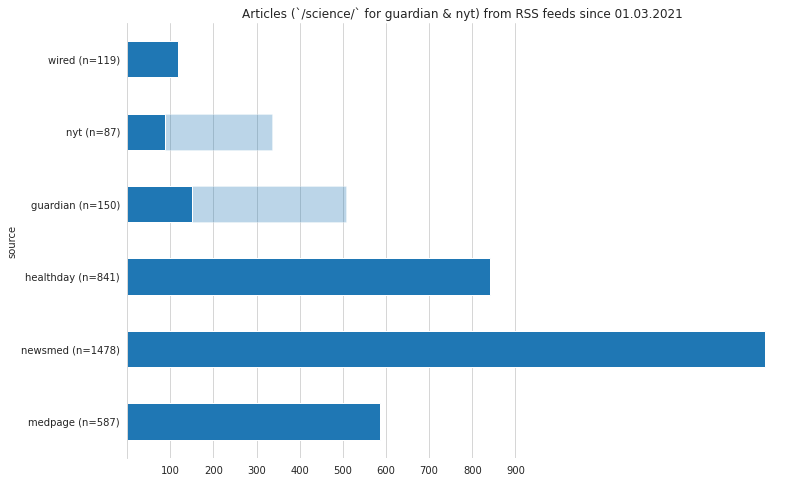

In [58]:
plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    ax = source_counts.loc[venue_names[::-1]].plot(kind="barh", alpha=.3)
    pdf = articles.groupby("source").size()
    pdf.loc[venue_names[::-1]].plot(kind="barh", ax=ax)
    sns.despine(bottom=True)
    plt.grid(False, axis="y")
    xticks = range(100, 1000, 100)
    yticks, labels = plt.yticks()
    labels = [f"{_.get_text()} (n={pdf[_.get_text()]})" for _ in labels]
    plt.yticks(ticks=yticks, labels=labels)
    plt.xticks(xticks, xticks)
    plt.title("Articles (`/science/` for guardian & nyt) from RSS feeds since 01.03.2021")

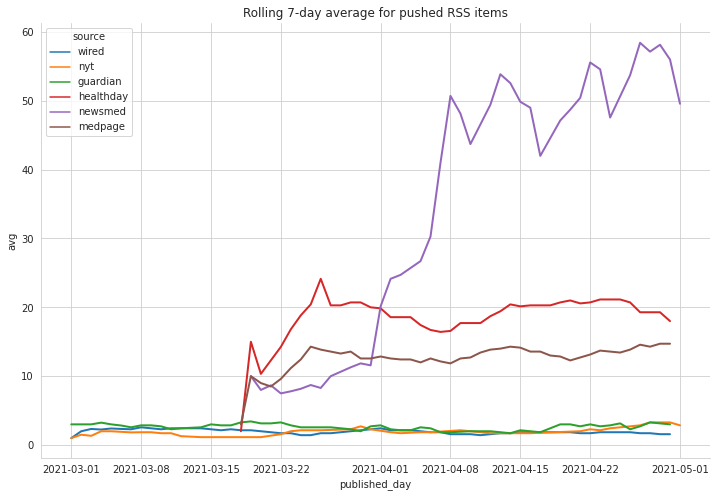

In [59]:
pdf = articles.groupby(["source", "published_day"], as_index=False)["link"].size()
pdf["avg"] = pdf.groupby("source").rolling(7, 1)["size"].mean().reset_index(drop=True)

plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    sns.lineplot(data=pdf, x="published_day", y="avg", hue="source", hue_order=venue_names, linewidth=2)
#     plt.xticks(rotation=45, ha="right");
    sns.despine()
    plt.title("Rolling 7-day average for pushed RSS items")

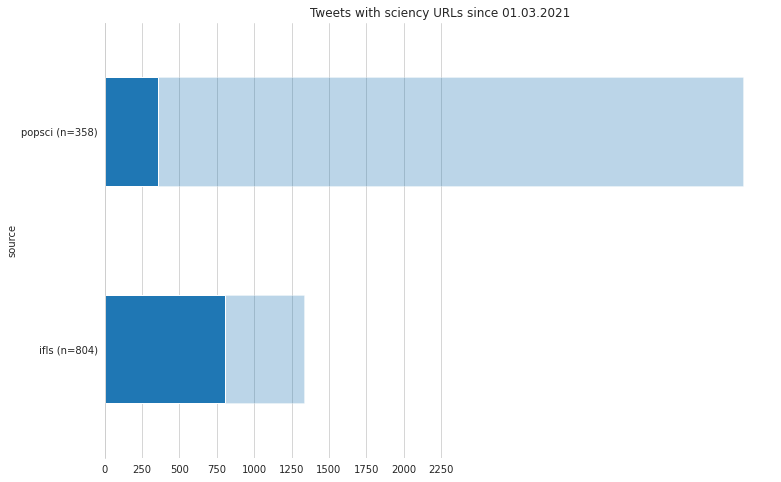

In [11]:
plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    source_counts = pd.Series(data=counts, index=short_names)
    ax = source_counts.plot(kind="barh", alpha=.3)
    pdf = df.groupby("source").size()
    pdf.plot(kind="barh", ax=ax)
    
    yticks, labels = plt.yticks()
    labels = [f"{_.get_text()} (n={pdf[_.get_text()]})" for _ in labels]
    plt.yticks(ticks=yticks, labels=labels)
    sns.despine(bottom=True)
    plt.grid(False, axis="y")
    xticks = range(0, 2500, 250)
    plt.xticks(xticks, xticks)
    plt.title("Tweets with sciency URLs since 01.03.2021")

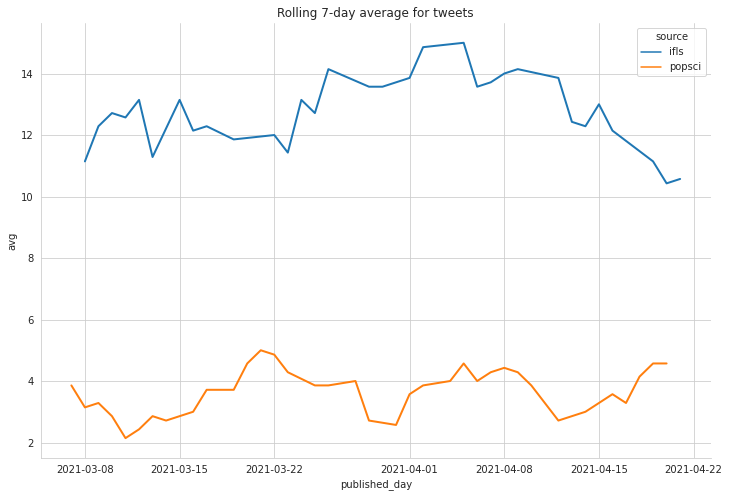

In [627]:
pdf = df.groupby(["source", "published_day"], as_index=False)["url"].size()
pdf["avg"] = pdf.groupby("source").rolling(7)["size"].mean().reset_index(drop=True)

plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    sns.lineplot(data=pdf, x="published_day", y="avg", hue="source", linewidth=2)
#     plt.xticks(rotation=45, ha="right");
    sns.despine()
    plt.title("Rolling 7-day average for tweets")

In [ ]:
plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    ax = source_counts.loc[venue_names[::-1]].plot(kind="barh", alpha=.3)
    articles.groupby("source").size().loc[venue_names[::-1]].plot(kind="barh", ax=ax)
    sns.despine(bottom=True)
    xticks = range(100, 1000, 100)
    plt.xticks(xticks, xticks)
    plt.title("Articles (`/science/` for guardian & nyt) from RSS feeds since 01.03.2021")